In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 技巧准备
### 4维数组
CNN中各层间传递的数据是4维数据。所谓4维数据，比如数据的形状是(10, 1, 28, 28)，则它对应10个高为28、长为28、通道为1的数据。用Python来实现的话，如下所示

In [2]:
x = np.random.randn(10, 1, 28, 28) # 随机生成数据
x.shape

(10, 1, 28, 28)

像这样，CNN中处理的是4维数据，因此卷积运算的实现看上去会很复杂，但是通过使用下面要介绍的 im2col 这个技巧，问题就会变得很简单。
### 基于im2col的展开
如果老老实实地实现卷积运算，估计要重复好几层的 for 语句。这样的实现有点麻烦，而且，NumPy中存在使用 for 语句后处理变慢的缺点（NumPy中，访问元素时最好不要用 for 语句）。这里，我们不使用 for 语句，而是使用 im2col 这个便利的函数进行简单的实现。
im2col 是一个函数，将输入数据展开以适合滤波器（权重）。如图7-17所示，对3维的输入数据应用 im2col 后，数据转换为2维矩阵（正确地讲，是把包含批数量的4维数据转换成了2维数据）。
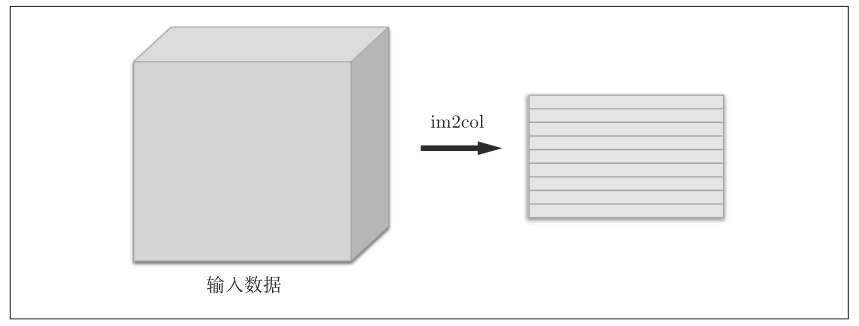

im2col 会把输入数据展开以适合滤波器（权重）。具体地说，如图7-18所示，对于输入数据，将应用滤波器的区域（3维方块）横向展开为1列。 im2col 会在所有应用滤波器的地方进行这个展开处理。
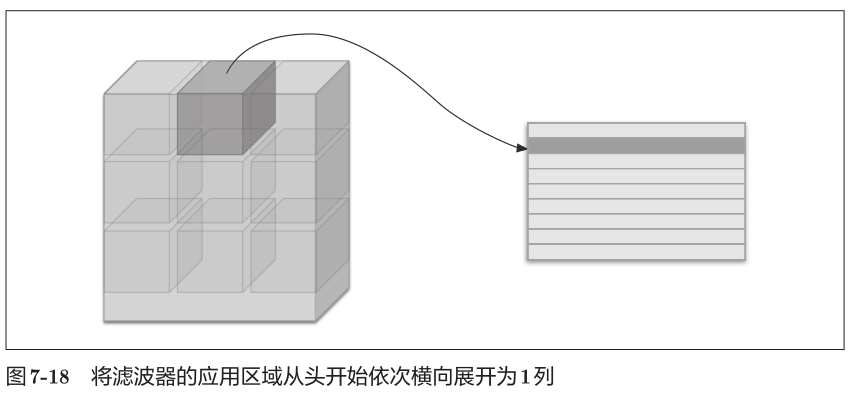
在图7-18中，为了便于观察，将步幅设置得很大，以使滤波器的应用区域不重叠。而在实际的卷积运算中，滤波器的应用区域几乎都是重叠的。在滤波器的应用区域重叠的情况下，使用 im2col 展开后，展开后的元素个数会多于原方块的元素个数。因此，使用 im2col 的实现存在比普通的实现消耗更多内存的缺点。但是，汇总成一个大的矩阵进行计算，对计算机的计算颇有益处。比如，在矩阵计算的库（线性代数库）等中，矩阵计算的实现已被高度最优化，可以高速地进行大矩阵的乘法运算。因此，通过归结到矩阵计算上，可以有效地利用线性代数库。
使用 im2col 展开输入数据后，之后就只需将卷积层的滤波器（权重）纵向展开为1列，并计算2个矩阵的乘积即可（参照图7-19）。这和全连接层的Affi ne层进行的处理基本相同。
如图7-19所示，基于 im2col 方式的输出结果是2维矩阵。因为CNN中数据会保存为4维数组，所以要将2维输出数据转换为合适的形状。以上就是卷积层的实现流程。
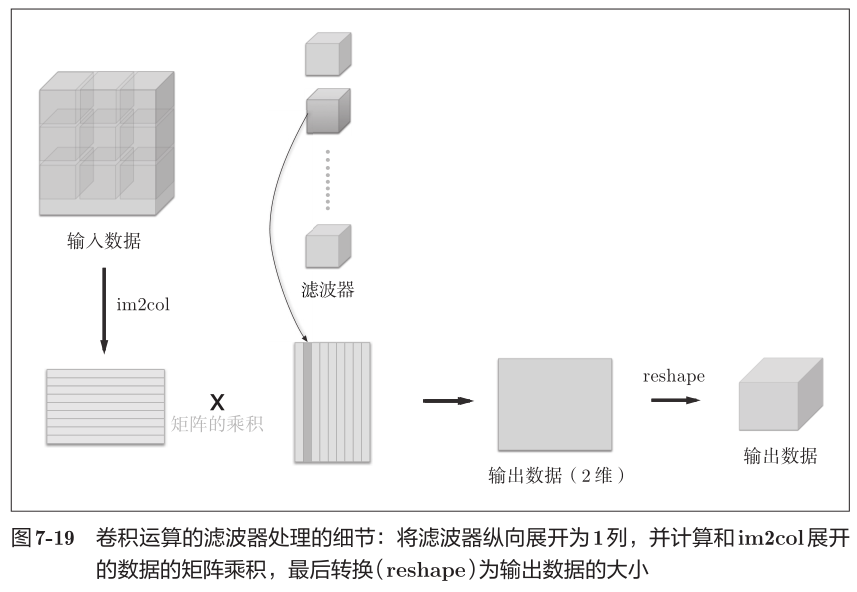

## 实现卷积神经网络
### 卷积层的实现
本书提供了 im2col 函数，并将这个 im2col 函数作为黑盒（不关心内部实现）使用。 im2col 的实现内容在 common/util.py 中，它的实现（实质上）是一个10行左右的简单函数。有兴趣的读者可以参考。
```
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : 由(数据量, 通道, 高, 长)的4维数组构成的输入数据
    filter_h : 滤波器的高
    filter_w : 滤波器的长
    stride : 步幅
    pad : 填充

    Returns
    -------
    col : 2维数组
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant') # 表示第一，第二维不填充数据，第三第四维两边填充pad数据。
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col
```

In [ ]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # 滤波器的展开
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        return out